# Image Segmentation with U-Net

<img src="images/carseg.png" style="width:500px;height:250;">
<caption><center> <u><b>Figure 1</u></b>: Example of a segmented image <br> </center></caption>

## Table of Content

- [1 - Packages](#1)
- [2 - Load and Split the Data](#2)
    - [2.1 - Split Your Dataset into Unmasked and Masked Images](#2-1)
    - [2.2 - Preprocess Your Data](#2-2)
- [3 - U-Net](#3)
    - [3.1 - Model Details](#3-1)
    - [3.2 - Encoder (Downsampling Block)](#3-2)
        - [Function 1 - conv_block](#ex-1)
    - [3.3 - Decoder (Upsampling Block)](#3-3)
        - [Function 2 - upsampling_block](#ex-2)
    - [3.4 - Build the Model](#3-4)
        - [Function 3 - unet_model](#ex-3)
    - [3.5 - Set Model Dimensions](#3-5)
    - [3.6 - Loss Function](#3-6)
    - [3.7 - Dataset Handling](#3-7)
- [4 - Train the Model](#4)
    - [4.1 - Create Predicted Masks](#4-1)
    - [4.2 - Plot Model Accuracy](#4-2)
    - [4.3 - Show Predictions](#4-3)

<a name='1'></a>
## 1 - Packages

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

<a name='2'></a>
## 2 - Load and Split the Data

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

### Check out the some of the unmasked and masked images from the dataset:

In [3]:
import imageio

C:\Users\HP\AppData\Local\Temp\ipykernel_13880\2281660190.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\HP\AppData\Local\Temp\ipykernel_13880\2281660190.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

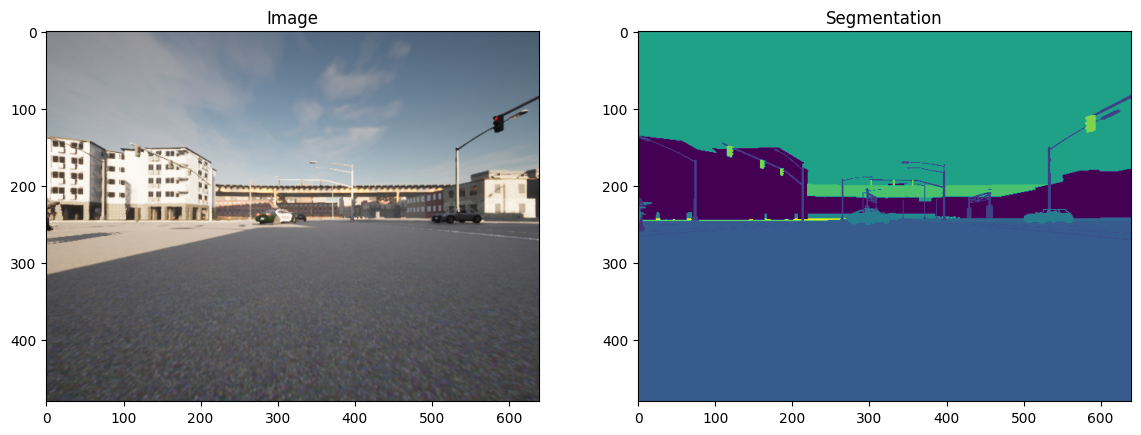

In [26]:
N = 1010
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='2-1'></a>
### 2.1 - Split Dataset into Unmasked and Masked Images

In [27]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

In [29]:
for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000028.png'>)


In [32]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/000026.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/000026.png', shape=(), dtype=string)


<a name='2-2'></a>
### 2.2 - Preprocess Data


In [33]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

<a name='3'></a>
## 3 - U-Net 

<a name='3-1'></a>
### 3.1 - Model Details

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total.

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 

<img src="images/encoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling. 

The function will  return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

<a name='ex-1'></a>
### Function 1 - conv_block

In [35]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)

    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<img src="images/decoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 

Here you'll encounter the `Conv2DTranspose` layer, which performs the inverse of the `Conv2D` layer. You can read more about it [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)


<a name='ex-2'></a>
### Function 2 - upsampling_block

In [36]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,# Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    return conv

<a name='3-4'></a>
### 3.4 - Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. That's because there are 23 possible labels for each pixel in this self-driving car dataset. 

In [37]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    # Include a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 

    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block 
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)
  

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
   
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
   
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [38]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [39]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
__________________________________________________________________________________________________


In [40]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

<a name='3-7'></a>
### 3.7 - Dataset Handling
Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible. 

In [41]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


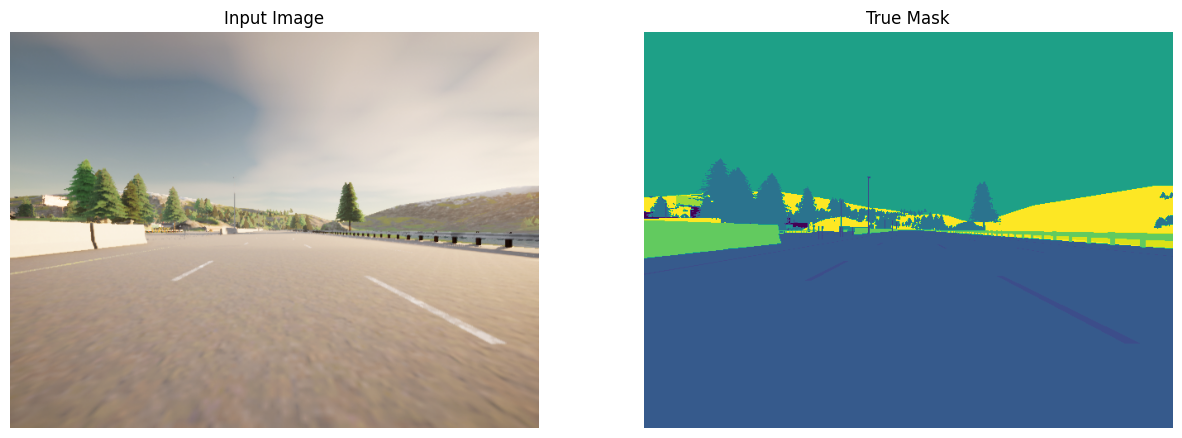

In [42]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


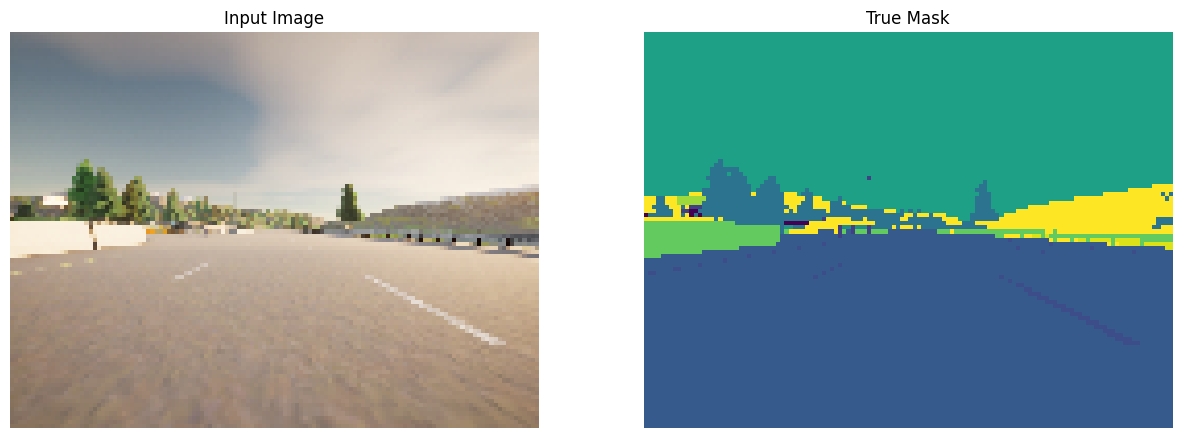

In [43]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

<a name='4'></a>
## 4 - Train the Model

In [44]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))


In [45]:
model_history = unet.fit(train_dataset, epochs=EPOCHS)

Epoch 1/40
34/34 [==============================] - 98s 2s/step - loss: 2.0293 - accuracy: 0.4115
Epoch 2/40
34/34 [==============================] - 40s 1s/step - loss: 0.9998 - accuracy: 0.7575
Epoch 3/40
34/34 [==============================] - 40s 1s/step - loss: 0.6085 - accuracy: 0.8267
Epoch 4/40
34/34 [==============================] - 40s 1s/step - loss: 0.4912 - accuracy: 0.8522
Epoch 5/40
34/34 [==============================] - 40s 1s/step - loss: 0.4009 - accuracy: 0.8793
Epoch 6/40
34/34 [==============================] - 41s 1s/step - loss: 0.3489 - accuracy: 0.8944
Epoch 7/40
34/34 [==============================] - 41s 1s/step - loss: 0.3147 - accuracy: 0.9053
Epoch 8/40
34/34 [==============================] - 41s 1s/step - loss: 0.2771 - accuracy: 0.9169
Epoch 9/40
34/34 [==============================] - 41s 1s/step - loss: 0.2512 - accuracy: 0.9247
Epoch 10/40
34/34 [==============================] - 40s 1s/step - loss: 0.2241 - accuracy: 0.9336
Epoch 11/40
34/34 [

<a name='4-1'></a>
### 4.1 - Create Predicted Masks 

In [46]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy

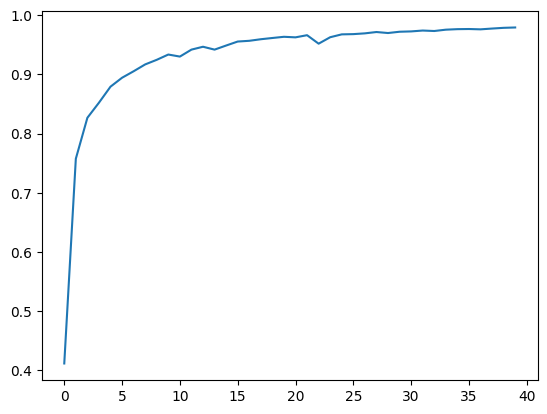

In [48]:
plt.plot(model_history.history["accuracy"])

<a name='4-3'></a>
### 4.3 - Show Predictions 

In [49]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 292ms/step


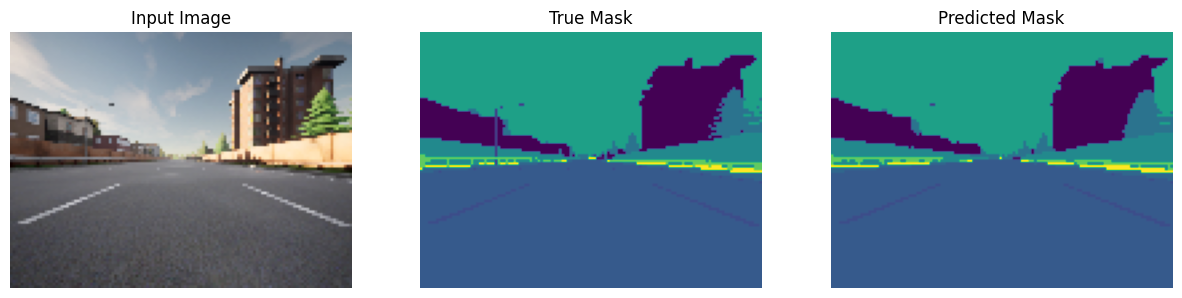

1/1 [==============================] - 0s 29ms/step


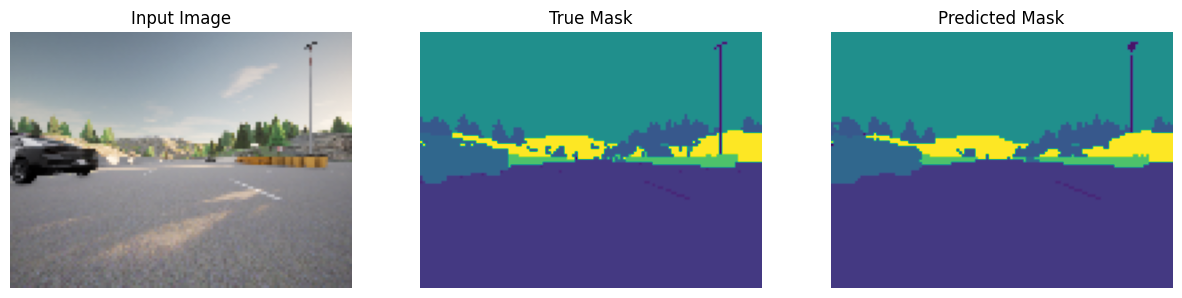

1/1 [==============================] - 0s 33ms/step


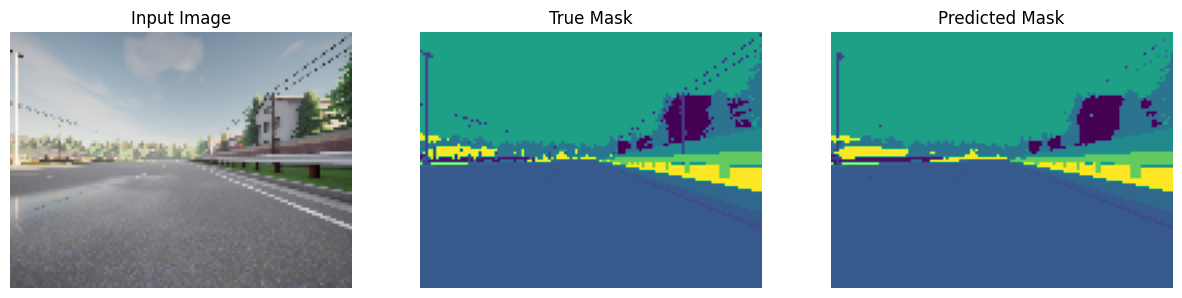

1/1 [==============================] - 0s 35ms/step


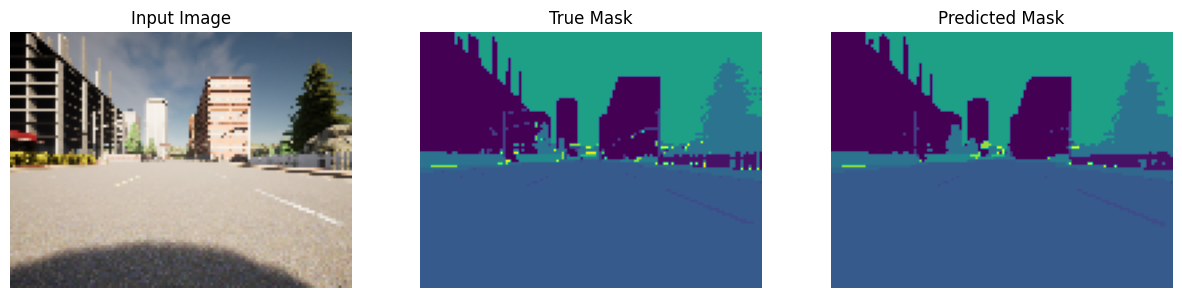

1/1 [==============================] - 0s 36ms/step


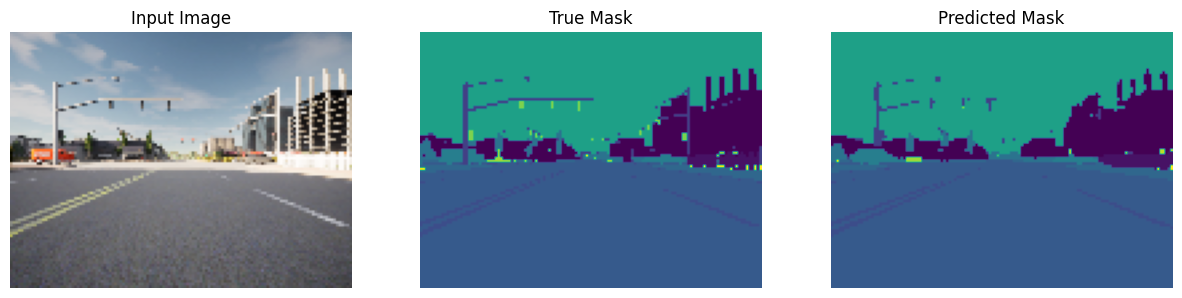

1/1 [==============================] - 0s 32ms/step


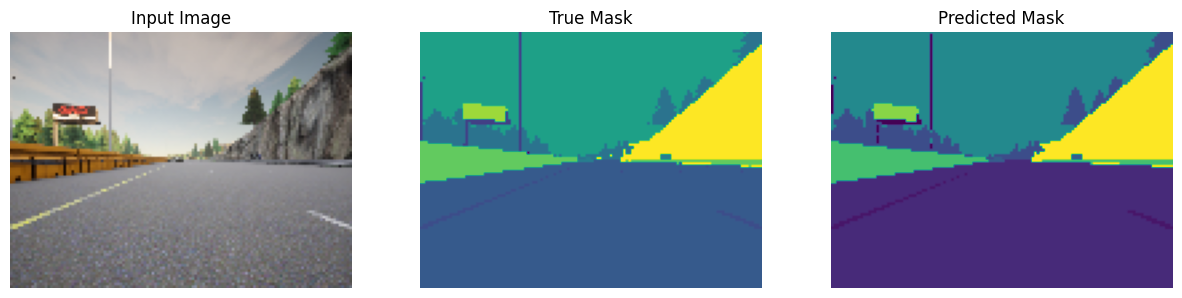

In [50]:
show_predictions(train_dataset, 6)

### Conclusion 

<font color='blue'>
    
**RECAP**: 

* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net